In [6]:
from ttslearn.tacotron import Tacotron2TTS
from tqdm.notebook import tqdm
import soundfile as sf

engine = Tacotron2TTS()
wav, sr = engine.tts("", tqdm=tqdm)
sf.write("test.wav", wav, sr)

  0%|          | 0/39600 [00:00<?, ?it/s]

In [1]:
1/(256)**(0.5)

0.0625

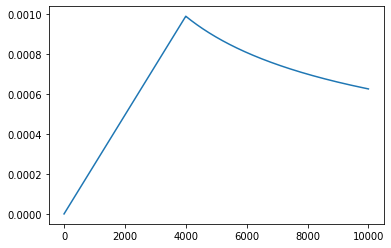

In [2]:
import torch
from vc_tts_template.fastspeech2 import FastSpeech2
from vc_tts_template.fastspeech2.optimizer import ScheduledOptim
import matplotlib.pyplot as plt
import numpy as np

model = FastSpeech2(
    max_seq_len=1000, num_vocab=52, encoder_hidden_dim=256, encoder_num_layer=2, encoder_num_head=2, conv_filter_size=256,
    conv_kernel_size=[9, 1], encoder_dropout=0.2, variance_predictor_filter_size=256, variance_predictor_kernel_size=5, variance_predictor_dropout=0.2,
    pitch_feature_level=1, energy_feature_level=1, pitch_quantization="linear", energy_quantization="linear",
    n_bins=256, decoder_hidden_dim=256, decoder_num_layer=4, decoder_num_head=2, decoder_dropout=0.2,
    n_mel_channel=80, =0, encoder_fix=False, stats={"pitch_min": 70, "pitch_max": 750, "energy_min": 10, "energy_max": 27}, 
    speakers=None
)

class ScheduledOptim_old:
    """ A simple wrapper class for learning rate scheduling """

    def __init__(self, optimizer, warm_up_step, anneal_steps, anneal_rate, current_step=0):

        self._optimizer = optimizer
        self.n_warmup_steps = warm_up_step
        self.anneal_steps = anneal_steps
        self.anneal_rate = anneal_rate
        self.current_step = current_step
        self.init_lr = 0.0625

    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        # print(self.init_lr)
        self._optimizer.zero_grad()

    def load_state_dict(self, path):
        self._optimizer.load_state_dict(path)

    def _get_lr_scale(self):
        lr = np.min(
            [
                np.power(self.current_step, -0.5),
                np.power(self.n_warmup_steps, -1.5) * self.current_step,
            ]
        )
        for s in self.anneal_steps:
            if self.current_step > s:
                lr = lr * self.anneal_rate
        return lr

    def _update_learning_rate(self):
        """ Learning rate scheduling per step """
        self.current_step += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group["lr"] = lr


optimizer_old = torch.optim.Adam(
            model.parameters(),
            betas=[0.9, 0.98],
            eps=0.000000001,
            weight_decay=0.0,
)
optimizer = torch.optim.Adam(
            model.parameters(),
            lr=0.0625,
            betas=[0.9, 0.98],
            eps=0.000000001,
            weight_decay=0.0,
)

# lr_scheduler_old = ScheduledOptim_old(optimizer_old, 4000, [300000, 400000, 500000], 0.3)
lr_scheduler = ScheduledOptim(4000, [300000, 400000, 500000], 0.3)
lr_scheduler._set_optimizer(optimizer)

# lrs_old = []
lrs_new = []

for _ in range(10000):
    # print("old current    step : ", lr_scheduler_old.current_step)
    # print("old current      lr : ", lr_scheduler_old._get_lr_scale() * lr_scheduler_old.init_lr)
    # print("old current  params : ", optimizer_old.param_groups[0]["lr"])
    # print("new current    step : ", lr_scheduler.last_epoch)
    # print("new current      lr : ", lr_scheduler.get_last_lr())
    # print("new current  params : ", optimizer.param_groups[0]["lr"])
    # print()
    # print("="*30)
    # lrs_old.append(optimizer_old.param_groups[0]["lr"])
    lrs_new.append(optimizer.param_groups[0]["lr"])

    # lr_scheduler_old.step_and_update_lr()
    lr_scheduler.step()

# plt.plot(lrs_old)
plt.plot(lrs_new)
plt.show()

In [34]:
torch.save(optimizer.state_dict(), "tmp.pth")
torch.save(lr_scheduler.state_dict(), "tmp_lr.pth")

Adam (
Parameter Group 0
    amsgrad: False
    betas: [0.9, 0.98]
    eps: 1e-09
    initial_lr: 0.0625
    lr: 0.0006249687523435547
    weight_decay: 0.0
)


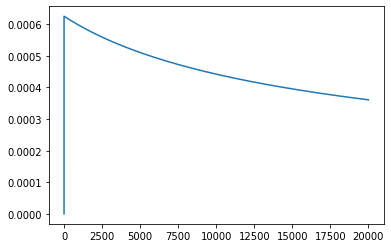

In [35]:
optimizer_new = torch.optim.Adam(
            model.parameters(),
            lr=0.0625,
            betas=[0.9, 0.98],
            eps=0.000000001,
            weight_decay=0.0,
)
optimizer_new.load_state_dict(torch.load("tmp.pth"))
print(optimizer_new)
lr_scheduler_ = ScheduledOptim(4000, [300000, 400000, 500000], 0.3)
lr_scheduler_._set_optimizer(optimizer_new)
lr_scheduler_.load_state_dict(torch.load("tmp_lr.pth"))

lrs_new_ = []

for _ in range(20000):
    lrs_new_.append(optimizer_new.param_groups[0]["lr"])
    lr_scheduler_.step()

plt.plot(lrs_new_)
plt.show()

In [ ]:
"""
結論
- 再現は意外と容易. last_epochと言いつつ, stepごとに更新される値を使って, get_lrを実装すればよいだけ.
- loadに関しては, lr_schedulerごと保存しないと意味がない. optimizerだけやっても, 最初から
lrのscheduleが始まるだけ.
"""

In [4]:
from vc_tts_template.fastspeech2 import FastSpeech2TTS
from scipy.io import wavfile

engine = FastSpeech2TTS(model_dir="./recipes/fastspeech2/tts_models/Long_dialogue_sr22050_Long_dialogue_1_fastspeech2wEmotion_hifigan")

Removing weight norm...


In [7]:
wav, sr = engine.tts("一貫学習にチャレンジしましょう！", emotion="joy")
wavfile.write("tmp.wav", sr, wav)

In [10]:
from glob import glob
import os
phase = "eval"
lst = glob("./recipes/fastspeech2/dump/jsut_sr22050/org/"+phase+"/in_fastspeech2/*.npy")

with open(phase+".list", 'w') as f:
    for name in lst:
        name = os.path.basename(name)
        f.write(name.replace("-feats.npy", "").strip()+'\n')

In [18]:
nepochs = 50
last_epoch = 10

from tqdm import tqdm
from time import sleep
epochs = tqdm(range(last_epoch+1, last_epoch+nepochs+1), total=last_epoch+nepochs, initial=last_epoch, desc="epoch")
for epoch in epochs:
    sleep(0.01)

epoch: 100%|██████████| 60/60 [00:00<00:00, 98.82it/s]


In [2]:
from pathlib import Path
from scipy.io import wavfile

wav_paths = Path("../dataset/out_Long_dialogue/Long_dialogue/wav/22050")

lengthes = []
length_map = {}
for wav_path in wav_paths.glob("*.wav"):
    sr_, wav = wavfile.read(wav_path)
    length = len(wav) / sr_

    lengthes.append(length)
    length_map[wav_path.name] = length

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

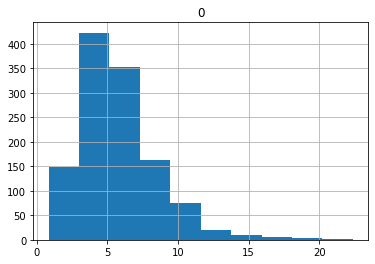

In [4]:
import pandas as pd 

df = pd.DataFrame(lengthes)
df.hist()

In [18]:
from pathlib import Path
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt

lab_paths = Path("../dataset/out_Long_dialogue/jl_out_lab")

lengthes = []
names = []
base_names = []
for lab_path in lab_paths.glob("*.lab"):
    with open(lab_path, 'r') as f:
        length = len(f.readlines())
    lengthes.append(length)
    names.append(lab_path.name)
    base_names.append(lab_path.name.split('-')[0])

df = pd.DataFrame({
    "phoneme_num": lengthes,
    "basename": base_names
})

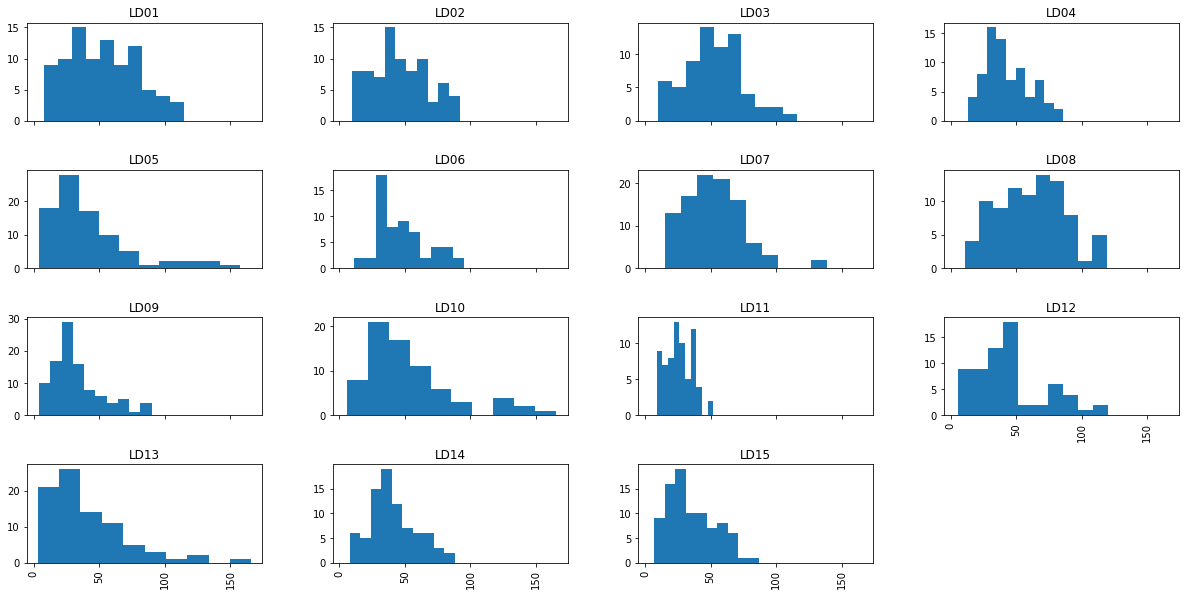

In [17]:
df.hist(column="phoneme_num", by="basename", figsize=(20,10), sharex=1)
plt.show()

In [20]:
import numpy as np
np.array(names)[np.array(lengthes) >= 150]

array(['LD13-Dialogue-05-Teacher-Turn-01_calm.lab',
       'LD05-Dialogue-10-Teacher-Turn-04_calm.lab',
       'LD10-Dialogue-10-Teacher-Turn-07_calm.lab'], dtype='<U43')

[5.306778  5.306778  5.306778  5.306778  5.306778  5.306778  5.306778
 5.306778  5.306778  5.306778  5.306778  5.306778  5.306778  5.306778
 5.3529315 5.349598  5.350495  5.3790097 5.4003377 5.410194  5.4237742
 5.437086  5.4408784 5.4306517 5.3724127 5.3376927 5.333244  5.3544273
 5.399623  5.472539  5.5443754 5.6056466 5.652719  5.6729884 5.660485
 5.6625433 5.6738605 5.679331  5.68483   5.68848   5.69066   5.696092
 5.703153  5.6763387 5.6487846 5.649     5.628016  5.611837  5.592307
 5.601939  5.6064434 5.5753365 5.545803  5.529382  5.514231  5.511809
 5.511911  5.5191174 5.522972  5.5503125 5.635289  5.693635  5.7359257
 5.7901506 5.848054  5.8886023 5.9230824 5.934368  5.9270267 5.9171867
 5.8974414 5.8372025 5.711224  5.6970468 5.6931863 5.6893106 5.6854196
 5.681514  5.6775923 5.6736555 5.669703  5.6657352 5.645353  5.590833
 5.504999  5.4553394 5.422756  5.3967752 5.3768153 5.3579235 5.3489237
 5.3032184 5.3093367 5.315418  5.321462  5.3274703 5.3334427 5.3393793
 5.345281  5.

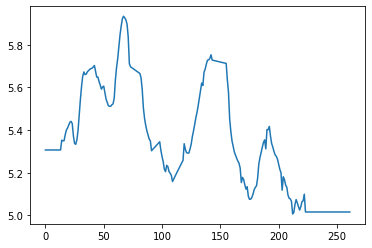

In [2]:
import numpy as np
import matplotlib.pyplot as plt

pitch = "recipes/fastspeech2VC/dump/jsut_jsss_1_sr22050/org/train/in_fastspeech2VC/pitch/jsut_jsss_BASIC5000_0001-feats.npy"
pitch = np.load(pitch)
print(pitch)
plt.plot(pitch)
plt.show()

In [8]:
# pyaudio
# install: https://www.javaer101.com/ja/article/30925973.html

import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from vc_tts_template.fastspeech2VC import FastSpeech2VC

########################################
rec_time = 1            # 計測時間[s]
samplerate = 22050  # サンプリングレート
fs = 1024           # フレームサイズ
index = 1           # マイクのチャンネル指標
model_name = ""
########################################

pa = pyaudio.PyAudio()
data = []
dt = 1 / samplerate

engine = FastSpeech2VC(model_name)

In [ ]:
# ストリームの開始
print("rec start....")
stream = pa.open(format=pyaudio.paInt16, channels=1, rate=samplerate,
                    input=True, input_device_index=index, frames_per_buffer=fs)

# フレームサイズ毎に音声を録音していくループ
for i in range(int(((rec_time / dt) / fs))):
    frame = stream.read(fs)
    data.append(frame)

# ストリームの終了
stream.stop_stream()
stream.close()
pa.terminate()
print("rec end")

# データをまとめる処理
data = b"".join(data)

# データをNumpy配列に変換
voice = np.frombuffer(data, dtype="int16") / float((np.power(2, 16) / 2) - 1)

wav, sr = engine.vc(voice, samplerate)

wavfile.write("test.wav", sr, wav)

In [10]:
from vc_tts_template.fastspeech2VC import FastSpeech2VC

engine = FastSpeech2VC(model_dir="recipes/fastspeech2VC/tts_models/jsut_jsss_sr22050_jsut_jsss_1_fastspeech2VC_hifigan")

Removing weight norm...


In [13]:
from scipy.io import wavfile

sr_, wav = wavfile.read("recipes/fastspeech2VC/downloads/jsut_jsss/source/jsut_jsss_BASIC5000_0001.wav")

wav, sr = engine.vc(wav, sr_)

wavfile.write("test.wav", sr, wav)

In [4]:
from pathlib import Path

wav_path = Path("recipes/fastspeech2VC/downloads/jsut_jsss_jvs/source")
spk_dict = {}

for wav in wav_path.glob("*.wav"):
    spk = wav.stem.split('_')[0]
    if spk not in spk_dict.keys():
        spk_dict[spk] = len(spk_dict)
    spk = wav.stem.split('_')[1]
    if spk not in spk_dict.keys():
        spk_dict[spk] = len(spk_dict)

In [5]:
spk_dict

{'jvs034': 0,
 'jvs002': 1,
 'jvs026': 2,
 'jvs056': 3,
 'JSUT': 4,
 'JSSS': 5,
 'jvs081': 6,
 'jvs012': 7,
 'jvs096': 8,
 'jvs052': 9,
 'jvs088': 10,
 'jvs057': 11,
 'jvs045': 12,
 'jvs010': 13,
 'jvs060': 14,
 'jvs091': 15,
 'jvs068': 16,
 'jvs047': 17,
 'jvs094': 18,
 'jvs071': 19,
 'jvs063': 20,
 'jvs087': 21,
 'jvs049': 22,
 'jvs007': 23,
 'jvs032': 24,
 'jvs070': 25,
 'jvs040': 26,
 'jvs013': 27,
 'jvs067': 28,
 'jvs084': 29,
 'jvs042': 30,
 'jvs024': 31,
 'jvs015': 32,
 'jvs095': 33,
 'jvs083': 34,
 'jvs020': 35,
 'jvs090': 36,
 'jvs093': 37,
 'jvs003': 38,
 'jvs038': 39,
 'jvs039': 40,
 'jvs031': 41,
 'jvs016': 42,
 'jvs046': 43,
 'jvs041': 44,
 'jvs055': 45,
 'jvs072': 46,
 'jvs018': 47,
 'jvs099': 48,
 'jvs033': 49,
 'jvs082': 50,
 'jvs069': 51,
 'jvs078': 52,
 'jvs023': 53,
 'jvs050': 54,
 'jvs058': 55,
 'jvs027': 56,
 'jvs004': 57,
 'jvs086': 58,
 'jvs005': 59,
 'jvs011': 60,
 'jvs017': 61,
 'jvs043': 62,
 'jvs051': 63,
 'jvs097': 64,
 'jvs061': 65,
 'jvs079': 66,
 'jvs001'

In [1]:
from pathlib import Path
from scipy.io import wavfile
import pyworld as pw
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor


wav_path_src = Path("recipes/fastspeech2VC/downloads/jsut_jsss_jvs/source")
wav_path_tgt = Path("recipes/fastspeech2VC/downloads/jsut_jsss_jvs/target")
hop_length = 256
n_jobs = 32

def preprocess(wav_path):
    sr, wav = wavfile.read(wav_path)
    pitch, t = pw.dio(
        wav.astype(np.float64),
        sr,
        frame_period=hop_length / sr * 1000,
    )
    pitch = pw.stonemask(wav.astype(np.float64),
                        pitch, t, sr)
    if np.sum(pitch != 0) <= 1:
        print(wav_path)


with ProcessPoolExecutor(n_jobs) as executor:
    futures = [
        executor.submit(
            preprocess,
            wav_path
        )
        for wav_path in list(wav_path_src.glob("*.wav")) + list(wav_path_tgt.glob("*.wav"))
    ]
    for future in tqdm(futures):
        future.result()


 16%|█▌        | 14438/90516 [05:30<28:58, 43.75it/s]


[ 21  68 115 167 236 344 411 458 496 580 603 651 728 858]
[ 21  68 114 143 222 369 412 463 512 609 631 673 754 871]


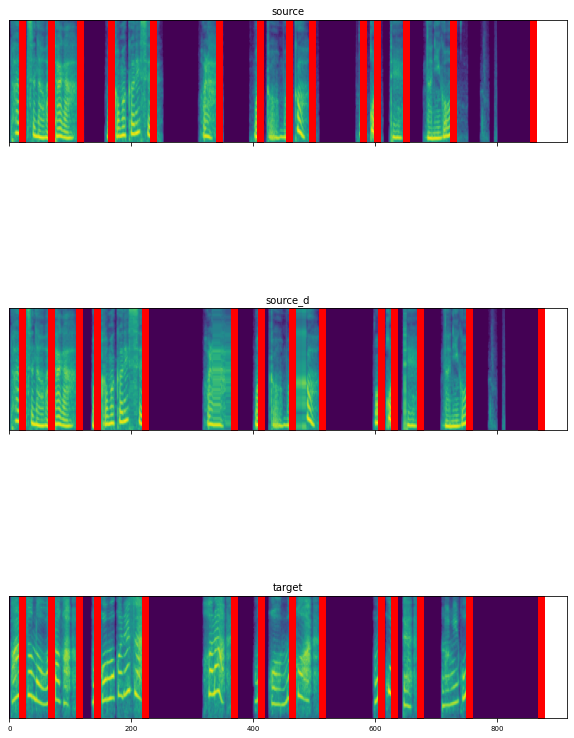

In [1]:
from recipes.fastspeech2VC.preprocess import get_sentence_duration, delete_novoice, calc_duration
from vc_tts_template.dsp import logmelspectrogram

from scipy.io import wavfile
import librosa
import numpy as np
import matplotlib.pyplot as plt

src_wav_path = "recipes/fastspeech2VC/downloads/N2C/source/n_c_fairy+-20.wav"
tgt_wav_path = "recipes/fastspeech2VC/downloads/N2C/target/n_c_fairy+-20.wav"

utt_id = "test"
sr = 22050
n_fft = 1024
hop_length = 256
win_length = 1024
fmin = 0
fmax = 8000
clip_thresh = 0.00001
log_base = "natural"
min_silence_len = 50
silence_thresh = -80
chunk_size = 50
reduction_factor = 1
silence_thresh_h = -50
silence_thresh_t = -100

src_wav, sr_src = delete_novoice(src_wav_path, silence_thresh_h, silence_thresh_t, chunk_size)
tgt_wav, sr_tgt = delete_novoice(tgt_wav_path, silence_thresh_h, silence_thresh_t, chunk_size)

src_wav = librosa.resample(src_wav, sr_src, sr)
tgt_wav = librosa.resample(tgt_wav, sr_tgt, sr)

src_sent_durations, tgt_sent_durations = get_sentence_duration(
    utt_id, src_wav, tgt_wav, sr, n_fft, hop_length, win_length,
    fmin, fmax, clip_thresh, log_base, reduction_factor,
    min_silence_len, silence_thresh
)
src_mel, energy = logmelspectrogram(
    src_wav, sr, n_fft, hop_length, win_length,
    80, fmin, fmax, clip=clip_thresh, log_base=log_base,
    need_energy=True
)
tgt_mel = logmelspectrogram(
    tgt_wav, sr, n_fft, hop_length, win_length,
    80, fmin, fmax, clip=clip_thresh, log_base=log_base,
    need_energy=False
)
duration = calc_duration([tgt_mel, src_mel], utt_id, np.log(energy+1e-6) < -5.0)
src_mel_after_duration = []
for i, d in enumerate(duration.astype(int)):
    for _ in range(d):
        src_mel_after_duration.append(list(src_mel[i]))
src_mel_after_duration = np.array(src_mel_after_duration)

def plot_mels(mels, d_points, titles=None):
    """mel: shape=(time, dim)
    """
    fig, axes = plt.subplots(len(mels), 1, squeeze=False, figsize=(10, 5*len(mels)), sharex=True)
    if titles is None:
        titles = [None for i in range(len(mels))]

    for i in range(len(mels)):
        mel = mels[i]
        d_point = d_points[i]
        axes[i][0].imshow(mel, origin="lower")
        axes[i][0].set_aspect(2.5, adjustable="box")
        axes[i][0].set_ylim(0, mel.shape[0])
        axes[i][0].set_title(titles[i], fontsize="medium")
        axes[i][0].tick_params(labelsize="x-small", left=False, labelleft=False)
        axes[i][0].set_anchor("W")
        for d in d_point:
            axes[i][0].plot([d]*mel.shape[1], range(mel.shape[1]), "ro")

    return fig

src_sent_durations = (src_sent_durations*reduction_factor).cumsum()
tgt_sent_durations = (tgt_sent_durations*reduction_factor).cumsum()
print(src_sent_durations)
print(tgt_sent_durations)
plot_mels([src_mel.T, src_mel_after_duration. T, tgt_mel.T], [src_sent_durations, tgt_sent_durations, tgt_sent_durations], ["source", "source_d", "target"])
plt.show()

In [ ]:
import torch

x = torch.Tensor([1])
print(id(x))
y = x.detach()
print(id(y))

y = y + torch.Tensor([2])
print(id(y))

y += torch.Tensor([2])
print(id(y))

print(x)
print(y)

x = torch.Tensor([1])
print(id(x))
y = x.detach()
print(id(y))

y += torch.Tensor([2])
print(id(y))

y = y + torch.Tensor([2])
print(id(y))

print(x)
print(y)

140340425343760
140340425333632
140334882528368
140334882528368
tensor([1.])
tensor([5.])
140334882589008
140340425333552
140340425333552
140340425333632
tensor([3.])
tensor([5.])


In [8]:
from sentence_transformers import SentenceTransformer
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

model = SentenceTransformer('all-mpnet-base-v2')
text1, text2 = model.encode(["月がきれいですね", "愛しています"])

print("cosine similarity: ", cos_sim(text1, text2))

model = SentenceTransformer("colorfulscoop/sbert-base-ja")
text1, text2 = model.encode(["月がきれいですね", "愛しています"])

print("cosine similarity: ", cos_sim(text1, text2))

print("="*30)

model = SentenceTransformer('all-mpnet-base-v2')
text1, text2 = model.encode(["あんたなんか、全然好きなんかじゃないんだからね！", "愛しています"])

print("cosine similarity: ", cos_sim(text1, text2))

model = SentenceTransformer("colorfulscoop/sbert-base-ja")
text1, text2 = model.encode(["あんたなんか、全然好きなんかじゃないんだからね！", "愛しています"])

print("cosine similarity: ", cos_sim(text1, text2))

print("="*30)

model = SentenceTransformer('all-mpnet-base-v2')
text1, text2 = model.encode(["嫌いです", "愛しています"])

print("cosine similarity: ", cos_sim(text1, text2))

model = SentenceTransformer("colorfulscoop/sbert-base-ja")
text1, text2 = model.encode(["嫌いです", "愛しています"])

print("cosine similarity: ", cos_sim(text1, text2))

cosine similarity:  0.6188397
cosine similarity:  0.35803473
cosine similarity:  0.6706692
cosine similarity:  0.3073956
cosine similarity:  0.7002877
cosine similarity:  0.42581898


In [9]:
print("="*30)

model = SentenceTransformer('all-mpnet-base-v2')
text1, text2 = model.encode(["二度と会いたくない", "毎日会いに来てほしい"])

print("cosine similarity: ", cos_sim(text1, text2))

model = SentenceTransformer("colorfulscoop/sbert-base-ja")
text1, text2 = model.encode(["二度と会いたくない", "毎日会いに来てほしい"])

print("cosine similarity: ", cos_sim(text1, text2))

cosine similarity:  0.7368731
cosine similarity:  0.51995426


In [3]:
import torch
import numpy as np

x = torch.tensor([1, np.inf, -np.inf])

torch.nn.Softmax()(x)

/tmp/ipykernel_388754/818370008.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.Softmax()(x)


tensor([nan, nan, nan])

In [3]:
import optuna
for _ in range(10):
    print(_)
    raise optuna.TrialPruned("hi")

0


TrialPruned: hi

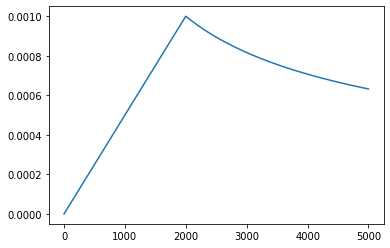

In [2]:
import numpy as np
import matplotlib.pyplot as plt
last_epoch = -1
n_warmup_step = 2500
base_lr = 0.0625
max_lr_scale = 0.016

lr_1_lst = []
lr_2_lst = []
lr_min_lst = []
max_over = 0
for _ in range(5000):
    last_epoch += 1
    lr_1 = np.power(last_epoch+1, -0.5)
    lr_2 = np.power(n_warmup_step, -1.5) * (last_epoch+1)
    lr_min = np.min([lr_1, lr_2])

    if lr_min > max_lr_scale:
        max_over = 1
    
    if max_over == 0:
        lr_min = np.min([lr_1, lr_2])
    else:
        lr_min = np.power((last_epoch+1)/np.power( (n_warmup_step**0.5) * max_lr_scale, 3), -0.5)
    lr_1_lst.append(lr_1 * base_lr)
    lr_2_lst.append(lr_2 * base_lr)
    lr_min_lst.append(lr_min * base_lr)

# plt.plot(lr_1_lst)
# plt.plot(lr_2_lst)
plt.plot(lr_min_lst)

last_epoch = -1
n_warmup_step = 4000
base_lr = 0.0625
max_lr = 0.001

lr_1_lst = []
lr_2_lst = []
lr_min_lst = []

for _ in range(10000):
    last_epoch += 1
    lr_1 = np.power(last_epoch+1, -0.5)
    lr_2 = np.power(n_warmup_step, -1.5) * (last_epoch+1)
    lr_min = np.min([lr_1, lr_2, max_lr/base_lr])
    lr_1_lst.append(lr_1 * base_lr)
    lr_2_lst.append(lr_2 * base_lr)
    lr_min_lst.append(lr_min * base_lr)

# plt.plot(lr_1_lst)
# plt.plot(lr_2_lst)
# plt.plot(lr_min_lst)


plt.show()